This is a notebook to write code to evaluate the metrics between pseudo-labels, refined pseudo-labels (statistic) and ground truth


In [2]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath(".."))

Load the scene_id and frame_id

In [3]:
# print(os.listdir(os.getcwd()))
feather_file = os.listdir(os.getcwd())[1]
#check i fwe have the right file
print(feather_file)

scene_id = feather_file.split("_")[-2]
frame_id = feather_file.split("_")[-1].split(".")[0]

filtered_bboxes_ff8e7fdb-1073-3592-ba5e-8111bc3ce48b_315968523660078000.feather


Load av2_dataloader

In [4]:
from av2.datasets.sensor.av2_sensor_dataloader import AV2SensorDataLoader
from pathlib import Path
from av2.structures.sweep import Sweep


home = os.path.join(os.path.expanduser('~'), "buni")

dataset_path = Path(os.path.join(home, "dataset", "av2", "train"))

av2 = AV2SensorDataLoader(data_dir=dataset_path, labels_dir=dataset_path)

# frame_path = av2.get_lidar_fpath_at_lidar_timestamp(scene_id, frame_id)

Some helper functions to convert gt_lables into 4x2 corner format

In [5]:
### create a dataset class to get labels and ground truth
import os
import pandas as pd
import numpy as np 
from typing import List, Tuple, Dict
from av2.datasets.sensor.av2_sensor_dataloader import AV2SensorDataLoader
from pathlib import Path

    
def extract_face_corners(cuboids: np.ndarray, bottom_face=True):
    """
    Extract corner coordinates of top or bottom face from cuboids.
    
    Args:
        cuboids: numpy array of shape (N, 8, 3) containing cuboid corner coordinates
        bottom_face: bool, if True return bottom face corners, else top face corners
    
    Returns:
        numpy array of shape (N, 4, 2) containing x,y coordinates of face corners
        
            5------4
            |\\    |\\
            | \\   | \\
            6--\\--7  \\
            \\  \\  \\ \\
        l    \\  1-------0    h
        e    \\ ||   \\ ||   e
        n    \\||    \\||   i
        g    \\2------3    g
            t      width.     h
            h.               t
    """
    # Select indices for bottom or top face
    face_index = [0, 1, 5, 4] if bottom_face else [3, 2, 6, 7]
    
    # Extract corners for selected face (x,y coordinates only)
    face_corners = cuboids[:, face_index, :2]
    
    return face_corners

def filter_cuboids_by_roi(corners: np.ndarray, config: Dict) -> np.ndarray:
    """
    Filter cuboids based on whether they fall within specified ROI.

    Args:
        corners: numpy array of shape (N, 4, 2) containing corner coordinates
        x_range: tuple of (min_x, max_x) defining ROI x bounds (0,70)
        y_range: tuple of (min_y, max_y) defining ROI y bounds  (-40,40)

    Returns:
        numpy array containing only cuboids that fall within ROI
    """
    
    x_min, x_max = config['GT_LABELS_ROI']['x_range']
    y_min, y_max = config['GT_LABELS_ROI']['y_range']
    
    filtered_cuboids = []
    for cuboid in corners:
        # Check if any corner falls within ROI
        if np.any((cuboid[:, 0] >= x_min) & 
                (cuboid[:, 0] <= x_max) & 
                (cuboid[:, 1] >= y_min) & 
                (cuboid[:, 1] <= y_max)):
            filtered_cuboids.append(cuboid)
    
    return np.array(filtered_cuboids)


config = {
    "GT_LABELS_ROI": {
        "x_range": (0, 70),
        "y_range": (-40, 40)
    }
}

                

load the gt_labels for given scene_id and frame_id, and transform them to right format

In [7]:
from config import CONFIG

if CONFIG['ROI']: 
    cuboids = av2.get_labels_at_lidar_timestamp(scene_id, int(frame_id)).vertices_m
    filtered_cuboids = filter_cuboids_by_roi(cuboids, config)
    gt_corners = extract_face_corners(filtered_cuboids)
else:
    cuboids = av2.get_labels_at_lidar_timestamp(scene_id, int(frame_id)).vertices_m
    gt_corners = extract_face_corners(cuboids)

Now we have gt_labels in the correct format. Time to load pseudo_labels and refined pseudo_labels

In [8]:
scene_id, frame_id

('ff8e7fdb-1073-3592-ba5e-8111bc3ce48b', '315968523660078000')

In [9]:
home = os.path.join(os.path.expanduser('~'), "buni")

pseudo_labels_dir = os.path.join(home, "output-data", "av2", "bbox_roi")

print(os.listdir(pseudo_labels_dir))

scene_path = os.path.join(pseudo_labels_dir, scene_id)
psudo_label_path = os.path.join(scene_path, f"{frame_id}.feather")
print(f"pseudo_label path exists: {os.path.exists(psudo_label_path)}")
print(psudo_label_path) 

pseudo_labels_df = pd.read_feather(psudo_label_path)

refined_psuedo_label_path = os.path.join(os.getcwd(), f"filtered_bboxes_{scene_id}_{frame_id}.feather")
print(f"refined pseudo_label path exists: {os.path.exists(refined_psuedo_label_path)}")
print(refined_psuedo_label_path)
refined_psuedo_labels_df = pd.read_feather(refined_psuedo_label_path)


['ff52c01e-3d7b-32b1-b6a1-bcff3459ccdd', 'ff6adc87-5f47-32f7-b36a-546453c0e332', 'ff8e7fdb-1073-3592-ba5e-8111bc3ce48b']
pseudo_label path exists: True
C:\Users\Ravi\buni\output-data\av2\bbox_roi\ff8e7fdb-1073-3592-ba5e-8111bc3ce48b\315968523660078000.feather
refined pseudo_label path exists: True
c:\Users\Ravi\buni\pseudo-labels\notebooks_experi\filtered_bboxes_ff8e7fdb-1073-3592-ba5e-8111bc3ce48b_315968523660078000.feather


We have pseudo_labels and refined pseudo_labels. Now, we convert them into right format and compute the metrics

First some functions for commputing metrics

In [10]:
from shapely.geometry import Polygon


def convert_format(boxes_array: np.ndarray) -> Tuple[np.ndarray, List[int]]:
    # boxes_array is a numpy array of shape (N, 4, 2)
    polygons = []
    err_idxs = []
    for idx, box in enumerate(boxes_array):
        try: 
            polygon = Polygon([(point[0], point[1]) for point in box] + [(box[0, 0], box[0, 1])])
            polygons.append(polygon)
        except Exception as e:
            print(f"Error converting bbox at index {idx}: {e}")
            err_idxs.append(idx)
                            
    return np.array(polygons), err_idxs

def compute_iou(box: Polygon, boxes: List[Polygon]):
    """Calculates IoU of the given box with the array of the given boxes.
    Note: the areas are passed in rather than calculated here for efficiency. 
    Calculate once in the caller to avoid duplicate work.
    
    Args:
        box: a polygon (shapely.geometry.Polygon)
        boxes: a numpy array of shape (N,), where each member is a shapely.geometry.Polygon
    Returns:
        a numpy array of shape (N,) containing IoU values
    """
    iou_lst = []
    for b in boxes:
        intersection = box.intersection(b).area
        union = box.union(b).area
        iou = intersection / union if union > 0 else 0
        iou_lst.append(iou)
    return np.array(iou_lst, dtype=np.float32)


def compute_overlaps(boxes1: np.ndarray, boxes2: np.ndarray):
    """Computes IoU overlaps between two sets of boxes.
    Returns an overlap matrix, which contains the IoU value for each combination of boxes.
    For better performance, pass the largest set first and the smaller second.
    
    Args: 
        boxes1: a numpy array of shape (N, 4, 2)
        boxes2: a numpy array of shape (M, 4, 2)
    Returns:
        overlaps: a numpy array of shape (N, M)
    """
    
    boxes1, _ = convert_format(boxes1)
    boxes2, _ = convert_format(boxes2)
    overlaps = np.zeros((len(boxes1), len(boxes2)))
    for i in range(overlaps.shape[1]):
        box2 = boxes2[i]
        overlaps[:, i] = compute_iou(box2, boxes1)
    return overlaps


def compute_matches(gt_boxes: np.ndarray, #label_list
                    pred_boxes: np.ndarray, # corner_list
                    iou_threshold=0.5, score_threshold=0.0):
    """Finds matches between prediction and ground truth instances.
    
    Args:
        gt_boxes: [N, 4, 2] Coordinates of ground truth boxes
        pred_boxes: [N, 4, 2] Coordinates of predicted boxes
        pred_scores: [N,] Confidence scores of predicted boxes
        iou_threshold: Float. IoU threshold to determine a match.
        score_threshold: Float. Score threshold to determine a match.
    Returns:
        gt_match: 1-D array. For each GT box it has the index of the matched
                  predicted box.
        pred_match: 1-D array. For each predicted box, it has the index of
                    the matched ground truth box.
        overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    if len(pred_boxes) == 0:
        return -1 * np.ones([gt_boxes.shape[0]]), np.array([]), np.array([])
    
    pred_scores = np.ones((len(pred_boxes),))

    gt_class_ids = np.ones(len(gt_boxes), dtype=int)
    pred_class_ids = np.ones(len(pred_scores), dtype=int)

    # Sort predictions by score from high to low
    indices = np.argsort(pred_scores)[::-1]
    pred_boxes = pred_boxes[indices]
    pred_class_ids = pred_class_ids[indices]
    pred_scores = pred_scores[indices]

    # Compute IoU overlaps [pred_boxes, gt_boxes]
    overlaps = compute_overlaps(pred_boxes, gt_boxes)

    # Loop through predictions and find matching ground truth boxes
    match_count = 0
    pred_match = -1 * np.ones([pred_boxes.shape[0]])
    gt_match = -1 * np.ones([gt_boxes.shape[0]])
    for i in range(len(pred_boxes)):
        # Find best matching ground truth box
        # 1. Sort matches by score
        sorted_ixs = np.argsort(overlaps[i])[::-1]
        # 2. Remove low scores
        low_score_idx = np.where(overlaps[i, sorted_ixs] < score_threshold)[0] #np.where returns a tuple (array, ) for 1D np array
        if low_score_idx.size > 0:
            sorted_ixs = sorted_ixs[:low_score_idx[0]]
        # 3. Find the match
        for j in sorted_ixs: 
            # If ground truth box is already matched, go to next one
            if gt_match[j] > 0:
                continue
            # If we reach IoU smaller than the threshold, end the loop
            iou = overlaps[i, j]
            if iou < iou_threshold:
                break #NOTE: sorted_ixs is in descending order, so if iou < iou_threshold, all the following ious will be less than iou_threshold
            # Do we have a match?
            if pred_class_ids[i] == gt_class_ids[j]:
                match_count += 1
                gt_match[j] = i
                pred_match[i] = j
                break

    return gt_match, pred_match, overlaps

def compute_ap(pred_match: np.ndarray, num_gt: int, num_pred: int):
    """ Compute Average Precision at a set IoU threshold (default 0.5).

        Args:
            pred_match: 1-D array. For each predicted box, it has the index of
                        the matched ground truth box.
            num_gt: Number of ground truth boxes
            num_pred: Number of predicted boxes
    """
    tp = (pred_match > -1).sum()
    # Compute precision and recall at each prediction box step
    precisions = np.cumsum(pred_match > -1) / (np.arange(num_pred) + 1)
    recalls = np.cumsum(pred_match > -1).astype(np.float32) / num_gt        
        
    precision = tp / num_pred
    recall = tp / num_gt
    return precision, recall

def compute_ap2(pred_match: np.ndarray, num_gt: int, num_pred: int) -> Tuple:
    """ Compute Average Precision at a set IoU threshold (default 0.5).

        Args:
            pred_match: 1-D array. For each predicted box, it has the index of
                        the matched ground truth box.
            num_gt: Number of ground truth boxes
            num_pred: Number of predicted boxes
            
        Returns:
            mAP: mean average precision
            precisions: precision values at each recall threshold
            recalls: recall values at each precision threshold
            precision: precision value
            recall: recall value
    """
    print(f"METHOD: compute_ap was called")
    assert num_gt != 0
    # assert num_pred != 0
    
    # Handle case when there are no predictions
    if num_pred == 0:
        print(f"METHOD: compute_ap: No predictions")
        # If there are no predictions, precision is 0 and recall depends on gt
        mAP = 0.0
        precisions = np.array([0,0])
        recalls = np.array([0, 1])  # Recall jumps from 0 to 1 over the recall range
        precision = 0.0
        recall = 0.0
        return mAP, precisions, recalls, precision, recall
    
    tp = (pred_match > -1).sum()
    # Compute precision and recall at each prediction box step
    precisions = np.cumsum(pred_match > -1) / (np.arange(num_pred) + 1)
    recalls = np.cumsum(pred_match > -1).astype(np.float32) / num_gt

    # Pad with start and end values to simplify the math
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    # Ensure precision values decrease but don't increase. This way, the
    # precision value at each recall threshold is the maximum it can be
    # for all following recall thresholds, as specified by the VOC paper.
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
                 precisions[indices])
    precision = tp / num_pred
    recall = tp / num_gt
    return mAP, precisions, recalls, precision, recall


Convert pseudo_labels and refined pseudo-labels into 4 corner format

In [11]:
from prototype_utils import bboxes_df_to_numpy_corners

pseudo_labels_corners = bboxes_df_to_numpy_corners(pseudo_labels_df)
refined_psuedo_labels_corners = bboxes_df_to_numpy_corners(refined_psuedo_labels_df)

Now we compute metricss. To compute metrics, first compute matches, and then actually compute metrics.

In [12]:
gt_match, pseudo_label_matches, overlaps = compute_matches(gt_corners, pseudo_labels_corners)
gt_length = len(gt_corners)
pseudo_label_length = len(pseudo_labels_corners)
compute_ap(pseudo_label_matches, gt_length, pseudo_label_length)

(0.05084745762711865, 0.03571428571428571)

In [13]:
gt_match, refined_pseudo_label_matches, overlaps = compute_matches(gt_corners, refined_psuedo_labels_corners)

refined_ps_len = len(refined_psuedo_labels_corners)

compute_ap(refined_pseudo_label_matches, gt_length, refined_ps_len)

(0.03125, 0.023809523809523808)

Great!! Now let's plot the pr curve of this using compute_ap2

In [14]:
import matplotlib.pyplot as plt

def plot_pr_curve_in_notebook(precisions, recalls, legend, name='PRCurve'):
    """
    Plot Precision-Recall Curve in a notebook environment.

    Args:
        precisions (list or np.ndarray): Precision values.
        recalls (list or np.ndarray): Recall values.
        legend (str): Legend text to display on the plot.
        name (str): Title of the plot.
    """
    fig, ax = plt.subplots()
    ax.plot(recalls, precisions, "-.", label=legend)
    ax.set_title(f"Precision-Recall Curve: {name}")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend(loc='upper right')
    ax.grid(True)
    plt.show()

# legend = f"AP@{mAP:.2f}"
# plot_pr_curve_in_notebook(precisions, recalls, legend)

METHOD: compute_ap was called


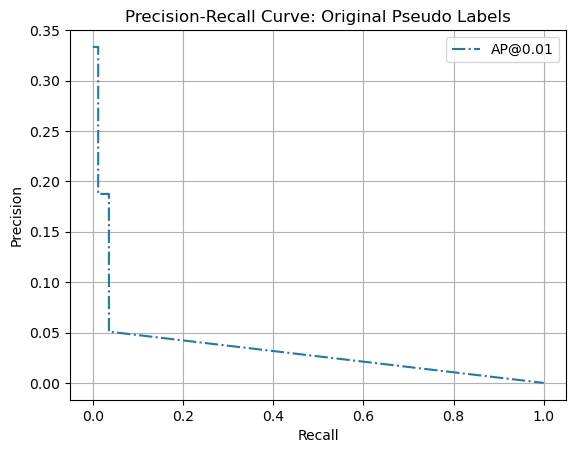

In [15]:
ps_original = compute_ap2(pseudo_label_matches, gt_length, pseudo_label_length)

plot_pr_curve_in_notebook(ps_original[1], ps_original[2], f"AP@{ps_original[0]:.2f}", "Original Pseudo Labels")

METHOD: compute_ap was called


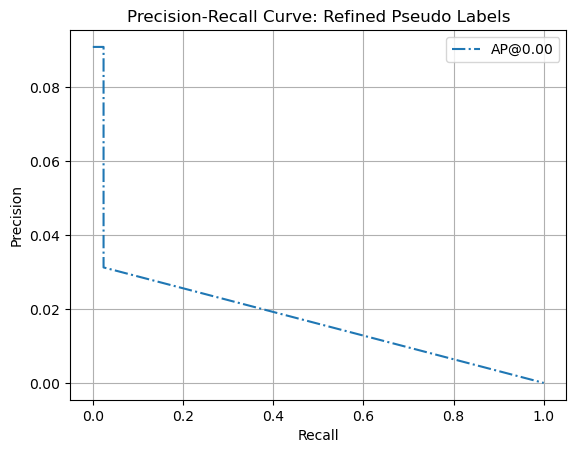

In [16]:
ps_refined = compute_ap2(refined_pseudo_label_matches, gt_length, refined_ps_len)

plot_pr_curve_in_notebook(ps_refined[1], ps_refined[2], f"AP@{ps_refined[0]:.2f}", "Refined Pseudo Labels")